# Learning: Part 1
Learning of simple models based on fuzzy logic.

In [1]:
import numpy as np
import torch

In [2]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [3]:
import sys
sys.path.insert(0, '../python')

In [4]:
from fuzzy_torch import logic

## The tipping problem

Example of fuzzy model that decides how much tips should be given.

**Input**: food_quality $ \in [0; 1] $, service_quality $ \in [0; 1] $.

**Output**: tips $ \in [0; 1] $.

In [5]:
# Selecting logic.
#Logic = logic.Godel
#Logic = logic.Product
#Logic = logic.Lukasiewicz
#Logic = logic.Nilpotent
Logic = logic.Hamacher

In [6]:
from fuzzy_torch.modules.indicators import BiSigmoid

In [7]:
class TipsModel(torch.nn.Module):
    """
    Simple fuzzy model for tips.
    """
    
    def __init__(self, logic):
        super().__init__()
        
        self.logic = logic
        
        self.food_is_bad  = BiSigmoid(-2.0, 0.2)
        self.food_is_good = BiSigmoid(2.0, 0.8)
        
        self.service_is_bad  = BiSigmoid(-2.0, 0.2)
        self.service_is_good = BiSigmoid(2.0, 0.8)
        
        self.low_tips    = torch.nn.Parameter(torch.ones(1) * 0.05)
        self.medium_tips = torch.nn.Parameter(torch.ones(1) * 0.1)
        self.high_tips   = torch.nn.Parameter(torch.ones(1) * 0.2)
        
    def forward(self, input):
        # Food quality.
        food_is_bad  = self.food_is_bad(input[:,0])
        food_is_good = self.food_is_good(input[:,0])
        food_is_ok   = self.logic.fuzzy_not(self.logic.fuzzy_or(food_is_bad, food_is_good))
        
        # Service quality.
        service_is_bad  = self.service_is_bad(input[:,1])
        service_is_good = self.service_is_good(input[:,1])
        service_is_ok   = self.logic.fuzzy_not(self.logic.fuzzy_or(service_is_bad, service_is_good))
        
        # RULES
        tips_are_low    = self.logic.fuzzy_and(food_is_bad, service_is_bad)
        tips_are_medium = service_is_ok
        tips_are_high   = self.logic.fuzzy_and(food_is_good, service_is_good)
        
        # Output.
        eps = 1e-7
        tips_are_low += eps
        tips_are_medium += eps
        tips_are_high += eps
        
        return (tips_are_low * self.low_tips + tips_are_medium * self.medium_tips + \
                tips_are_high * self.high_tips) / (tips_are_low + tips_are_medium + tips_are_high)

In [8]:
model = TipsModel(Logic)

### Data for learning

In [9]:
# Обучающая выборка
train_X = np.array([
    [0.2, 0.4],
    [0.6, 0.6],
    [0.1, 0.2],
    [0.7, 0.3],
    [0.8, 0.9],
    [0.9, 0.7],
    [0.3, 0.1],
    [0.2, 0.2],
    [0.2, 0.5],
    [0.3, 0.6],
    [0.9, 0.9],
]).astype(np.float32)

train_y = np.array([
    0.05,
    0.07,
    0.01,
    0.07,
    0.2,
    0.15,
    0.01,
    0.02,
    0.05,
    0.07,
    0.2,
]).astype(np.float32)

### Inference surface

In [10]:
N_fq = 101
N_sq = 101

eps = 1e-7
food_quality_axis = torch.linspace(eps, 1.0 - eps, N_fq)
service_quality_axis = torch.linspace(eps, 1.0 - eps, N_sq)

# Grid.
food_quality_grid, service_quality_grid = torch.meshgrid(food_quality_axis, service_quality_axis, indexing="xy")
food_quality    = food_quality_grid.flatten()[:,None]
service_quality = service_quality_grid.flatten()[:,None]

In [11]:
grid_X = torch.cat((food_quality, service_quality), dim=1)

In [12]:
def plot_inference_surface(model, grid_X, train_X, train_y):
    grid_y = model(grid_X).detach().numpy().reshape((N_fq, N_sq))

    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(12)
    fig.set_figwidth(12)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    cfset = ax.contourf(food_quality_axis, service_quality_axis, grid_y, cmap='Blues', levels=20)
    ax.scatter(train_X[:,0], train_X[:,1], c=train_y, cmap='Blues', s=200)
    
    ax.set_xlabel('Food quality')
    ax.set_ylabel('Service quality')

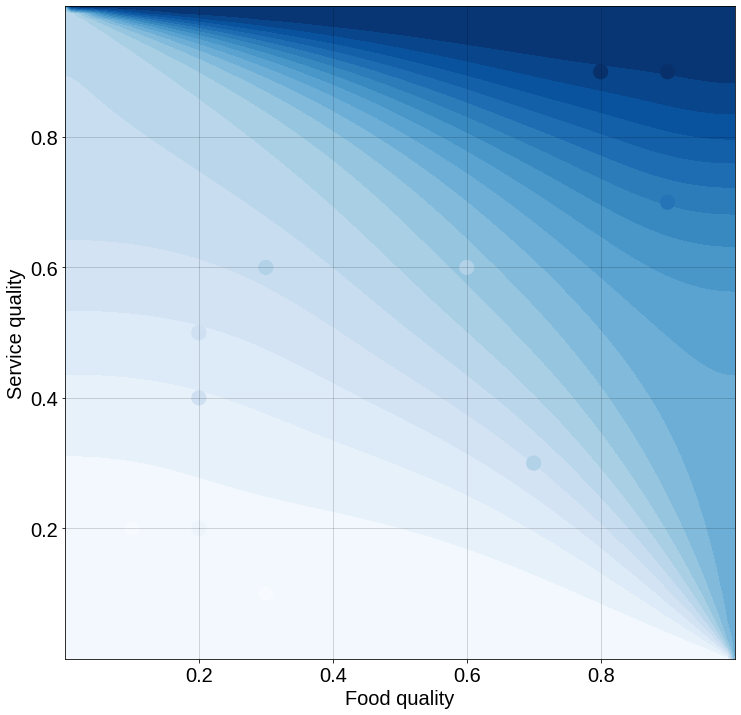

In [13]:
plot_inference_surface(model, grid_X, train_X, train_y)

### Learning

In [14]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_X), torch.tensor(train_y))

In [15]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
)

In [16]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.05)#, momentum=0.9)

In [17]:
loss = torch.nn.MSELoss()

for epoch in range(500):
    running_loss = []
    for i, data in enumerate(train_dataloader, 0):
        x, true_y = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y = model(x)
        eval_loss = loss(y, true_y)
        eval_loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(eval_loss.item())
        
    running_loss = np.array(running_loss)
    print(f"[{epoch + 1}] loss: {np.mean(running_loss):.1e}")
    running_loss = 0.0

print('Finished Training')

[1] loss: 6.3e-04
[2] loss: 6.8e-04
[3] loss: 6.3e-04
[4] loss: 1.9e-04
[5] loss: 2.3e-04
[6] loss: 4.8e-04
[7] loss: 3.4e-04
[8] loss: 1.3e-04
[9] loss: 1.6e-04
[10] loss: 2.8e-04
[11] loss: 2.6e-04
[12] loss: 1.7e-04
[13] loss: 1.2e-04
[14] loss: 1.2e-04
[15] loss: 1.7e-04
[16] loss: 1.9e-04
[17] loss: 1.5e-04
[18] loss: 9.4e-05
[19] loss: 8.6e-05
[20] loss: 1.2e-04
[21] loss: 1.3e-04
[22] loss: 9.9e-05
[23] loss: 6.5e-05
[24] loss: 7.0e-05
[25] loss: 9.5e-05
[26] loss: 9.8e-05
[27] loss: 7.6e-05
[28] loss: 5.5e-05
[29] loss: 5.7e-05
[30] loss: 7.0e-05
[31] loss: 7.2e-05
[32] loss: 5.8e-05
[33] loss: 4.7e-05
[34] loss: 5.0e-05
[35] loss: 5.9e-05
[36] loss: 5.7e-05
[37] loss: 4.6e-05
[38] loss: 4.1e-05
[39] loss: 4.5e-05
[40] loss: 4.9e-05
[41] loss: 4.6e-05
[42] loss: 4.1e-05
[43] loss: 4.0e-05
[44] loss: 4.2e-05
[45] loss: 4.3e-05
[46] loss: 4.0e-05
[47] loss: 3.7e-05
[48] loss: 3.8e-05
[49] loss: 4.0e-05
[50] loss: 3.8e-05
[51] loss: 3.4e-05
[52] loss: 3.4e-05
[53] loss: 3.5e-05
[5

[434] loss: 1.5e-05
[435] loss: 1.5e-05
[436] loss: 1.5e-05
[437] loss: 1.5e-05
[438] loss: 1.5e-05
[439] loss: 1.5e-05
[440] loss: 1.5e-05
[441] loss: 1.5e-05
[442] loss: 1.5e-05
[443] loss: 1.5e-05
[444] loss: 1.5e-05
[445] loss: 1.5e-05
[446] loss: 1.5e-05
[447] loss: 1.5e-05
[448] loss: 1.5e-05
[449] loss: 1.5e-05
[450] loss: 1.5e-05
[451] loss: 1.5e-05
[452] loss: 1.5e-05
[453] loss: 1.5e-05
[454] loss: 1.5e-05
[455] loss: 1.5e-05
[456] loss: 1.5e-05
[457] loss: 1.5e-05
[458] loss: 1.5e-05
[459] loss: 1.5e-05
[460] loss: 1.5e-05
[461] loss: 1.5e-05
[462] loss: 1.5e-05
[463] loss: 1.5e-05
[464] loss: 1.5e-05
[465] loss: 1.5e-05
[466] loss: 1.5e-05
[467] loss: 1.5e-05
[468] loss: 1.5e-05
[469] loss: 1.5e-05
[470] loss: 1.5e-05
[471] loss: 1.5e-05
[472] loss: 1.5e-05
[473] loss: 1.5e-05
[474] loss: 1.5e-05
[475] loss: 1.4e-05
[476] loss: 1.4e-05
[477] loss: 1.4e-05
[478] loss: 1.4e-05
[479] loss: 1.4e-05
[480] loss: 1.4e-05
[481] loss: 1.4e-05
[482] loss: 1.4e-05
[483] loss: 1.4e-05


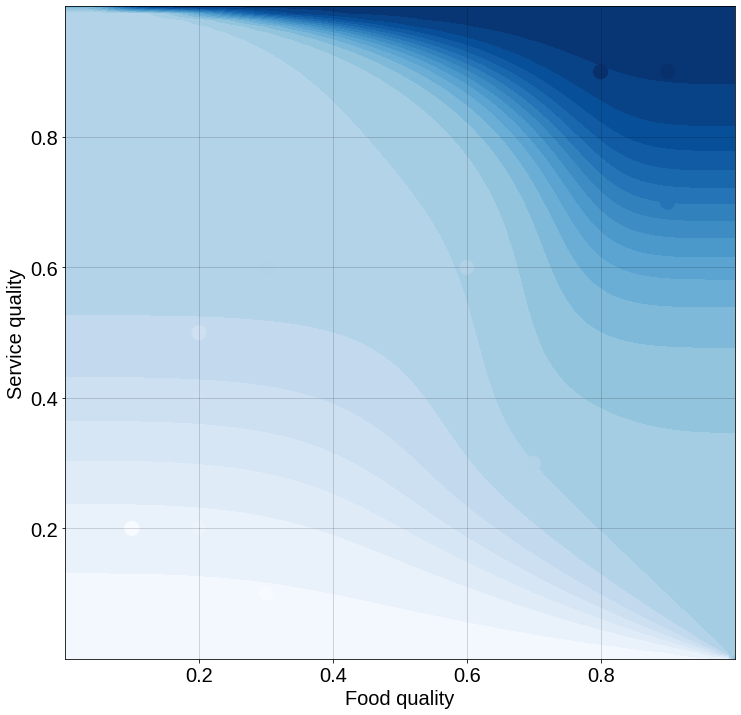

In [18]:
plot_inference_surface(model, grid_X, train_X, train_y)

### Learned parameters

Let's print learned model parameters.

In [19]:
print("Tips share:")
print("Low tips:\t%.3f" % model.low_tips)
print("Medium tips:\t%.3f" % model.medium_tips)
print("High tips:\t%.3f" % model.high_tips)

Tips share:
Low tips:	0.007
Medium tips:	0.073
High tips:	0.204


In [20]:
print("Food quality fuzzy sets params:\n")

print("Food is bad:")
print("Weight:\t%.3f" % model.food_is_bad.weight.item())
print("Offset:\t%.3f" % model.food_is_bad.offset.item())

print()

print("Food is good:")
print("Weight:\t%.3f" % model.food_is_good.weight.item())
print("Offset:\t%.3f" % model.food_is_good.offset.item())

Food quality fuzzy sets params:

Food is bad:
Weight:	-2.427
Offset:	-0.412

Food is good:
Weight:	3.924
Offset:	1.405


In [21]:
def plot_food_quality_fuzzy_sets(model, X):
    food_is_bad  = model.food_is_bad(X[:,None])
    food_is_good = model.food_is_good(X[:,None])
    
    food_is_ok   = model.logic.fuzzy_not(model.logic.fuzzy_or(food_is_bad, food_is_good))
    
    food_is_bad  = food_is_bad.detach().numpy().squeeze()
    food_is_ok   = food_is_ok.detach().numpy().squeeze()
    food_is_good = food_is_good.detach().numpy().squeeze()

    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(12)
    fig.set_figwidth(18)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(X, food_is_bad, label="Food is bad")
    ax.plot(X, food_is_ok, label="Food is ok")
    ax.plot(X, food_is_good, label="Food is good")
    
    ax.set_xlabel('Food quality')
    ax.set_ylabel('Fuzzy variable')
    
    ax.legend(loc="upper left")

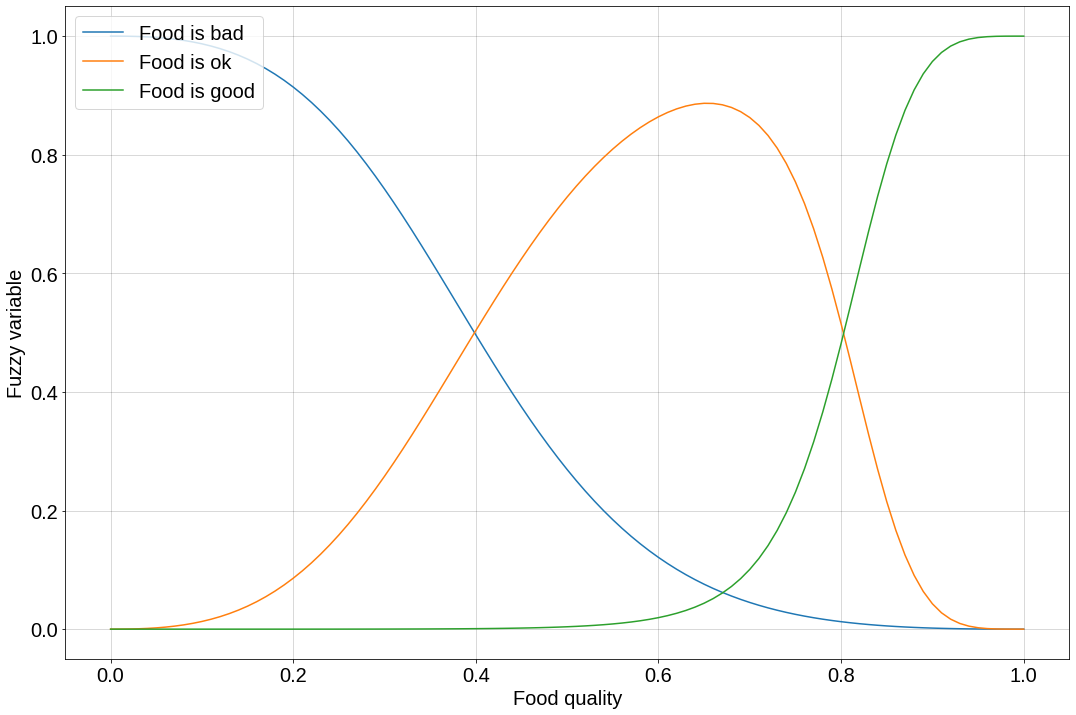

In [22]:
plot_food_quality_fuzzy_sets(model, torch.linspace(0.0, 1.0, 101))

In [23]:
print("Service quality fuzzy sets params:\n")

print("Service is bad:")
print("Weight:\t%.3f" % model.service_is_bad.weight.item())
print("Offset:\t%.3f" % model.service_is_bad.offset.item())

print()

print("Service is good:")
print("Weight:\t%.3f" % model.service_is_good.weight.item())
print("Offset:\t%.3f" % model.service_is_good.offset.item())

Service quality fuzzy sets params:

Service is bad:
Weight:	-2.348
Offset:	-0.559

Service is good:
Weight:	2.700
Offset:	0.706


In [24]:
def plot_service_quality_fuzzy_sets(model, X):
    service_is_bad  = model.service_is_bad(X[:,None])
    service_is_good = model.service_is_good(X[:,None])
    
    service_is_ok   = model.logic.fuzzy_not(model.logic.fuzzy_or(service_is_bad, service_is_good))
    
    service_is_bad  = service_is_bad.detach().numpy().squeeze()
    service_is_ok   = service_is_ok.detach().numpy().squeeze()
    service_is_good = service_is_good.detach().numpy().squeeze()

    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(12)
    fig.set_figwidth(18)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(X, service_is_bad, label="Service is bad")
    ax.plot(X, service_is_ok, label="Service is ok")
    ax.plot(X, service_is_good, label="Service is good")
    
    ax.set_xlabel('Service quality')
    ax.set_ylabel('Fuzzy variable')
    
    ax.legend(loc="upper left")

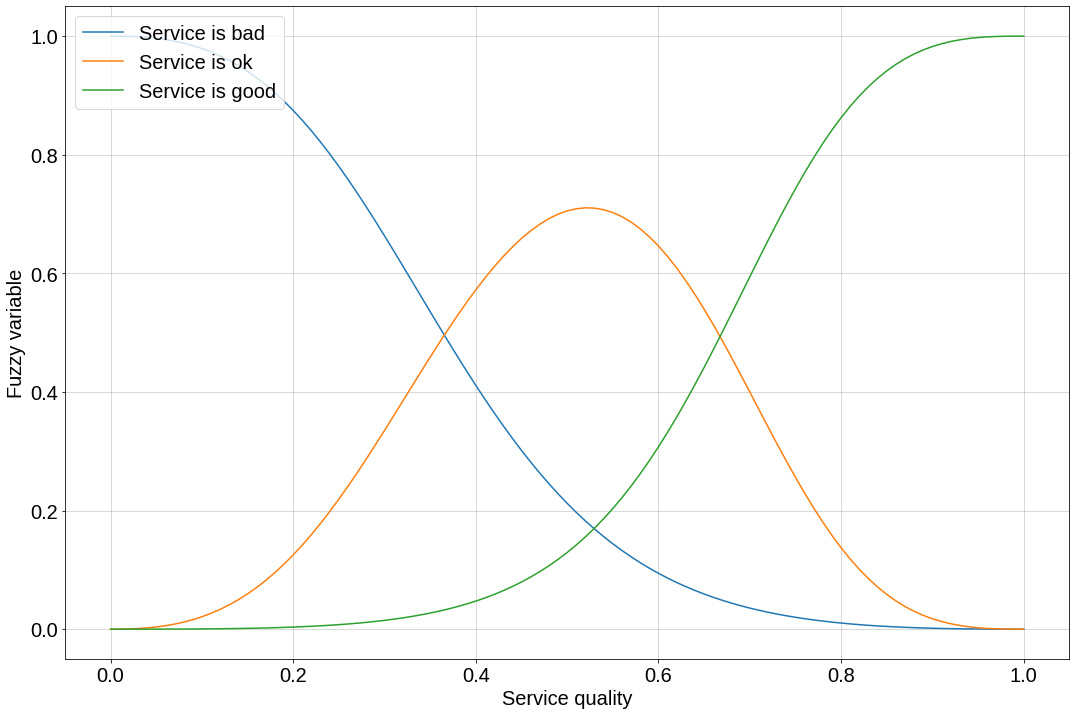

In [25]:
plot_service_quality_fuzzy_sets(model, torch.linspace(0.0, 1.0, 101))